<a href="https://colab.research.google.com/github/vuvu43/Film-Poster-Classifier/blob/main/filme_poster_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#imports utilizados
import numpy as np #algebra linear
import pandas as pd #data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 as cv #manipulação de imagem
import requests #baixar iamgens
import matplotlib.pyplot as plt
import os
import glob
import shutil

def delete_directory(directory_path):
    """
    Deleta o diretório inteiro e todo o seu conteúdo.

    Entrada:
        - str directory_path: Caminho do diretório a ser deletado.
    """
    if os.path.exists(directory_path):
        shutil.rmtree(directory_path)
        print(f"O diretório '{directory_path}' foi deletado com sucesso.")
    else:
        print(f"O diretório '{directory_path}' não existe.")

delete_directory("sample_data")

# paths importantes através do código
path_to_images = "/content/MoviePoster15k/*.jpg"
path_to_csv = "MovieGenre.csv"


path_to_image_dir = "/content/MoviePoster15k"
if not os.path.exists(path_to_image_dir):
    print(f"Diretório '{path_to_image_dir}' criado.")
    os.makedirs(path_to_image_dir)

# Trabalho Final - Introdução ao Aprendizado de Máquina

É possível descobrir o gênero de um filme apenas pelo seu pôster? Considerando apenas pela memória, a "vibe" de um filme costuma ser retratada pelo seu pôster, aqui vamos tentar formalizar isso e tentar treinar modelos de classificação para checar se tais modelos são capazes de fazer isso também

Para esse trabalho, o dataset escolhido é constituído de 1 arquivo CSV e uma pasta com os pôsteres dos filmes, o arquivo CSV é bem simples, com apenas 6 colunas, então vamos observar quais informações podem ser tiradas dele primeiro.


# Tratando Dados Parte 1

A primeira parte do tratamento de dados consistirá basicamente em manipular o dataset para tirar informações que serão relevantes mais tarde na hora da construção dos modelos


In [20]:
# Primeiramente, vamos carregar o arquivo csv e ver um pouco de como é a cara dele
df = pd.read_csv(path_to_csv, encoding="ISO-8859-1")
df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


In [21]:
#  A coluna de gêneros é com certeza muito importante para o objetivo desse trabalho
# vamos tentar extrair em quais gêneros os filmes foram classificados no total

def extract_genres(df:pd.DataFrame):
    genres_set = set()

    for genre in df["Genre"]:
        #computar apenas se for realmente string, caso contrário ignora
        if isinstance(genre, str):
            splitted = genre.split("|")
            genres_set.update(splitted)

    return list(genres_set)

#dropando linhas que possuam um pelo menos 1 valor NaN
df = df.dropna()

#extraindo gêneros...
genres = extract_genres(df)
print(len(genres))
genres

28


['Sci-Fi',
 'History',
 'Short',
 'Game-Show',
 'Western',
 'News',
 'Talk-Show',
 'Film-Noir',
 'Documentary',
 'Sport',
 'Adventure',
 'Reality-TV',
 'Romance',
 'Crime',
 'Drama',
 'Mystery',
 'Thriller',
 'Biography',
 'War',
 'Fantasy',
 'Music',
 'Animation',
 'Action',
 'Adult',
 'Family',
 'Comedy',
 'Musical',
 'Horror']

São 28 gêneros no total, pessoalmente, alguns desses não me interessam e portanto e não acho que é sejam interessante de se fazer alguma análise então irei retirar alguns
e deixarei apenas os seguinte selecionados

*  Action
*  Comedy
*  Musical
*  Sci-fi
*  Drama
*  Documentary
*  Horror
*  Romance
*  Crime


In [22]:
selected_genres = ["Action", "Comedy", "Musical", "Sci-Fi", "Drama", "Documentary", "Horror", "Romance", "Crime"]
print(f"No total, os filmes serão classificados  em {len(selected_genres)} gêneros.")

No total, os filmes serão classificados  em 9 gêneros.


In [23]:
import random

# Por motivos de simplificação, também quero que cada filme seja
# associado a apenas uma classe, e é justamente isso que faço aqui

def choose_random_genre(genre_str):
    genre_list = genre_str.split('|')

    # Filtra os gêneros dos filmes que estão na lista dos selecionados
    valid_genres = [genre for genre in genre_list if genre in selected_genres]

    # Se existir pelo menos um gênero válido, escolhe um aleatoriamente
    if valid_genres:
        return random.choice(valid_genres)
    else:
        # retorna None para depois a linha ser dropada
        return None

# aplica a função em toda a coluna
df["Genre"] = df["Genre"].apply(choose_random_genre)

# dropa linhas com nan
df = df.dropna()

#teste
for x in df["Genre"]:
    if x not in selected_genres:
        print("Algo deu errado...", x)

df["Genre"]

0         Comedy
1         Action
2         Comedy
3          Drama
4        Romance
          ...   
40102     Action
40103      Drama
40104     Comedy
40105     Horror
40106     Comedy
Name: Genre, Length: 37251, dtype: object

Agora com os gêneros escolhidos, podemos passar para a segunda parte, que consistirá em checar a pasta com pôsteres. Acontece que a pasta disponibilizada não possui todos os filmes listados no arquivo csv, e não só isso, mas a maioria dos filmes lá são bem antigos. Então, para tentar remover o viés do tempo, irei desconsiderar as imagens disponibilizadas e baixar novas, que irão fazer o conjunto de treino+teste, no total irei tentar baixar cerca de 10.000 imagens.

In [24]:
#Vamos deixar nosso conjunto de treino+teste, por volta de 15.000 imagens

def download_images(df:pd.DataFrame, save_directory:str, downloads:int, age:int) -> pd.DataFrame:
    """
    Faz o download de imagens a partir dos links na coluna 'Poster' do DataFrame
    e salva no diretório especificado,verificando se a imagem já está baixada antes
    de fazer o download. Ao mesmo tempo que as imagens forem baixadas, o df será
    atualizado para conter apenas as imagens baixadas.

    Entrada:
        - pd.DataFrame df: DataFrame contendo uma coluna 'Poster' com links para as imagens.
        - str save_directory: caminho do diretório onde as imagens serão salvas.
        - int downloads: quantidade total de filmes que devem ser baixados
        - int age: filmes baixados terão que ser feitos a partir de 'age'

    Saída:
        -pd.DataFrame: DataFrame atualizado com os filmes de interesse
    """
    if os.path.exists(save_directory):
        downloaded_dir = os.listdir(save_directory)
        downloaded_dir = [x.replace(".jpg", "") for x in downloaded_dir]
    downloaded = 0 #quantidade de downloads bem sucedidos
    downloaded_images_data = [] #lista para guardar informacoes para o novo df

    # itera sobre as linhas do df
    for _, row in df.iterrows():
        if downloaded > downloads:
            break

        if downloaded%1000 == 0:
            print("Downloaded:", downloaded)

        film_age = row["Title"].replace("(", "").replace(")", "")[-4:]
        try: #se o filme não houver idade declarada dará um erro
        #se a idade do filme for menor que a imposta -> ignora filme
            if int(film_age) < age:
                continue
        except: #se ocorrer um erro -> ignore o filme
            continue

        image_id = row['imdbId']
        # se a imagem já tiver sido baixada, pula
        if image_id in downloaded_dir:
            downloaded +=1
            continue

        image_url = row['Poster']
        file_path = os.path.join(save_directory, f"{image_id}.jpg")

        #verifica se a imagem já está baixada
        if os.path.exists(file_path):
            downloaded_images_data.append(row) #guarda informações da imagem já baixada
            downloaded += 1
            continue
        else:
            try:
                response = requests.get(image_url, stream=True)

                #se a imagem está no link disponibilizado
                if response.status_code == 200:
                    downloaded_images_data.append(row)
                    downloaded += 1

                    #salva a imagem no diretório especificado
                    with open(file_path, 'wb') as file:
                        for chunk in response.iter_content(1024):
                            file.write(chunk)
                else:
                  continue

            #caso aconteça algum erro
            except Exception as e:
                continue

    print("Imagens baixadas com sucesso")
    return pd.DataFrame(downloaded_images_data, columns=df.columns)

In [25]:
df = download_images(df, path_to_image_dir, downloads=15_000, age=1950)
#df = pd.read_csv("Movies15k.csv")

Downloaded: 0
Downloaded: 1000
Downloaded: 2000
Downloaded: 3000
Downloaded: 4000
Downloaded: 5000
Downloaded: 6000
Downloaded: 7000
Downloaded: 8000
Downloaded: 9000
Downloaded: 10000
Downloaded: 10000
Downloaded: 11000
Downloaded: 12000
Downloaded: 13000
Downloaded: 14000
Downloaded: 15000
Imagens baixadas com sucesso


In [26]:
# Com o novo df em mãos quero guardar ele em um novo csv para praticidade
df.to_csv("/content/MoviesGenre15k.csv", index=False)

# Tratando Dados Parte 2
Finalmente com nossas imagens em mãos podemos começar a manipular elas para que estejam próprias para uso em nossos classificadores

In [ ]:
# A intuição por trás de pegar os menores valores da largura e altura dentre as
# imagens, é para que todas tenham o mesmo tamanho para poderem entrar na rede neural
# ao mesmo tempo que perdem o mínimo de informação necessária

def get_min_shapes(image_path:str) -> tuple[int, int]:
    """
    Recebe caminho para as imagens e retorna os menores
    largura e altura dentre as imagens

    Entrada:
        - str image_path: caminho para as imagens
    Saída:
        - tuple[int, int] (min_h, min_w): menores altura e largura encontrados
    """

    #pega caminho para as imagens em uma lista
    image_files = glob.glob(image_path)

    #init vars
    min_h = 10_000
    min_w = 10_000

    #iterando sobre todas as imagens
    for image_file in image_files:
        img = cv.imread(image_file)

        h, w, _ = img.shape

        #pega menor largura e altura da imagem
        if h < min_h:
            min_h = h
        if w < min_w:
            min_w = w

    return (min_h, min_w)

get_min_shapes(path_to_images)

(268, 182)

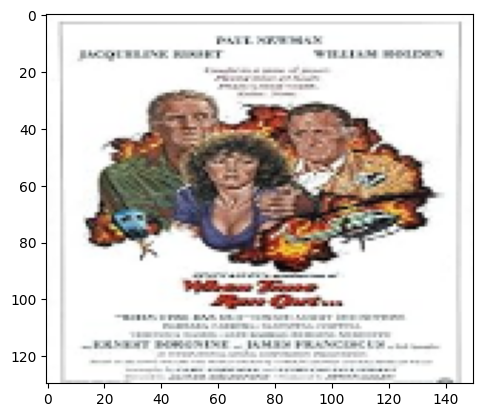

In [ ]:
# Precisamos fazer um resize em todas as imagens para que
# sejam todas do mesmo tamanho

def prepare_data(goal_size:tuple[int, int], image_path:str) -> np.array:
    """
    Faz com que todas as imagens disponíveis sejam carregadas no programa
    e retorna um vetor com todas elas do tamaho desejado

    Entrada:
        - int h_resized: altura desejada
        - int w_resized: largura desejado
        - str image_path: caminho para as imagens
    Saída:
        - numpy.array resized_images: imagens com o tamanho correto
                                      guardados em um vetor
    """

    image_files = glob.glob(image_path)
    resized_images = []

    for path in image_files:
        poster = cv.imread(path) #lê imagem
        poster_resized = cv.resize(poster, goal_size) #redimensiona imagem
        resized_images.append(poster_resized) #adiciona imagem numa lista

    return np.array(resized_images) #retorna lista de imagens

# Tentei rodar usando os menores valores de encontrados mas ele acaba dando
# erro por que consome toda a memória do colab, então vou usar esses
# valores como um limite superior para o tamanho das imagens
goal_size = (128, 128)
resized_images = prepare_data(goal_size, path_to_images)

# por padrão, a biblioteca openCV utiliza o padrão BGR ao invés do RGB
# por isso a conversão (não será feito novamente, apenas para demonstração)
img_ex = cv.cvtColor(resized_images[0], cv.COLOR_BGR2RGB)
plt.imshow(img_ex)

# Modelos de classificação
Como foi pedido na descrição do trabalho, este projeto conssitirá de 2 classificadores, cada um deles será separado em "Modelo 1" e "Modelo 2". O primeiro modelo será uma rede neural

## Modelo 1
Como discutido acima, o primeiro modelo será uma rede neural, ela terá uma entrada de 268*182 = 48.778 (e ainda com 3 canais de cor) neurônios e uma saída de 10 neurônios

In [ ]:
# Bibliotecas utilizadas para a rede neural
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import Adam

In [ ]:
resized_images = resized_images[:len(df)]
print(len(resized_images))
print(len(df))

# um último teste para saber se está tudo ok...
for x in df["Genre"]:
    if x not in selected_genres:
        print(f"Gênero {x} não foi selecionado")
        break

5001
5001


In [ ]:
mlb = MultiLabelBinarizer(classes=selected_genres)
encoded_labels = mlb.fit_transform(df['Genre'])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['-', 'A', 'C', 'D', 'F', 'H', 'M', 'R', 'S', 'a', 'c', 'd', 'e', 'i', 'l', 'm', 'n', 'o', 'r', 's', 't', 'u', 'y'] will be ignored
  warnings.warn(


In [ ]:
# Separando os dados em treino e teste usando stratified
X_train, X_test, y_train, y_test = train_test_split(resized_images,
                                                    encoded_labels,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=encoded_labels)

# Normalizar os dados para estarem no range de [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
# Construindo a rede neural convolucional
model = Sequential()

# Camada de entrada (convolucional)
model.add(Conv2D(16, (3, 3), activation="relu", input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))

# Camada convolucional 1
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))

# Camada convolucional 2
model.add(Conv2D(16, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())

# Camada escondida 1
model.add(Dense(128, activation="relu"))

# Camada escondida 2
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))

# Camada de saída
model.add(Dense(len(mlb.classes_), activation="softmax"))

In [ ]:
# Compilando modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# Treinando o modelo
history = model.fit(X_train, y_train, epochs=20)

Epoch 1/15
125/125 [==============================] - 4s 21ms/step - loss: 0.0168 - accuracy: 0.1497
Epoch 2/15
125/125 [==============================] - 3s 21ms/step - loss: 0.0012 - accuracy: 0.1390
Epoch 3/15
125/125 [==============================] - 3s 20ms/step - loss: 0.0012 - accuracy: 0.1300
Epoch 4/15
125/125 [==============================] - 3s 22ms/step - loss: 4.6156e-04 - accuracy: 0.1517
Epoch 5/15
125/125 [==============================] - 3s 23ms/step - loss: 1.8949e-04 - accuracy: 0.0432
Epoch 6/15
125/125 [==============================] - 3s 20ms/step - loss: 1.3182e-04 - accuracy: 0.0870
Epoch 7/15
125/125 [==============================] - 3s 20ms/step - loss: 3.0025e-05 - accuracy: 0.0918
Epoch 8/15
125/125 [==============================] - 3s 20ms/step - loss: 1.5366e-04 - accuracy: 0.1010
Epoch 9/15
125/125 [==============================] - 3s 22ms/step - loss: 1.2292e-04 - accuracy: 0.1388
Epoch 10/15
125/125 [==============================] - 3s 24ms/step

In [ ]:
# Criar o modelo
model = Sequential()

# Camada de entrada (convolucional)
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Camada convolucional 1
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Camada convolucional 2
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Camada convolucional 3
model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Camada de Flatten
model.add(Flatten())

# Camada densa 1
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))

# Camada densa 2
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))

# Camada de saída
model.add(Dense(len(mlb.classes_), activation="sigmoid"))

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Visualizar a arquitetura do modelo
model.summary()

# Treinando o modelo
history = model.fit(X_train, y_train, epochs=15)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 128, 148, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 128, 148, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 64, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 62, 72, 64)        18496     
                                                                 
 batch_normalization_5 (Bat  (None, 62, 72, 64)        256       
 chNormalization)                                                
                                                      